# Data collection

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df=pd.read_csv("labeledTrainData.tsv",sep="\t")

df.columns=["i","category","content"]

df=df.dropna(subset=["category","content"])

from nltk import word_tokenize     #tokenize words according to spaces


df["category"].value_counts()

num_classes = len(df["category"].unique())

In [3]:
df

,i,category,content
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


# Tokenize：

In [4]:
import jieba
sentence=[i.split(" ") for i in df["content"]]

# Training word embedding with embedding size 128 and 10 epochs


In [5]:
import pandas as pd
import gensim
# w2v_model = gensim.models.Word2Vec(sentence, size=128, iter=10, min_count=0)
# word_vectors = w2v_model.wv
# w2v_model.save("w2v")
w2v_model=gensim.models.Word2Vec.load("w2v")

In [6]:
from keras.layers import *
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


# Vectorize the texts, transfer label into onehot, pad zeros

In [7]:
content=[]
for j in sentence:
    content+=j

tokenizer = Tokenizer()
tokenizer.fit_on_texts(content)  #transfer texts into vectors
train_sequence = tokenizer.texts_to_sequences(sentence)
MAX_SEQUENCE_LENGTH=128 # Maximum length of a sentence
EMBEDDING_DIM = 128 
y_train =df["category"]
y_train = to_categorical(y_train)  
y_train = y_train.astype(np.int32)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
train_pad = pad_sequences(train_sequence, maxlen=MAX_SEQUENCE_LENGTH) #pad zeros according to Maximum length

Found 88582 unique tokens.


In [8]:
tf.test.is_gpu_available()

True

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM), dtype=np.float32)
not_in_model = 0
in_model = 0
embedding_max_value = 0
embedding_min_value = 1
not_words = []

for word, i in word_index.items():
    if word in w2v_model:
        in_model += 1
        embedding_matrix[i] = np.array(w2v_model[word])
        embedding_max_value = max(np.max(embedding_matrix[i]), embedding_max_value)
        embedding_min_value = min(np.min(embedding_matrix[i]), embedding_min_value)
    else:
        not_in_model += 1
        not_words.append(word)

# Define a embedding layer

In [10]:
embed = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
				  trainable=True)  

# Divide the data for training and validation

In [11]:
train_data, val_data, train_y, val_y = train_test_split(train_pad, y_train, test_size=0.2, random_state=43)

# APDCNN

In [12]:
def get_attentionpool_model(Embedding):
    inputs_sentence = Input(shape=(MAX_SEQUENCE_LENGTH,))  # input layer
    sentence =(Embedding(inputs_sentence))  #word embedding layer
    s = LSTM(64, return_sequences=True)(sentence)  # lstm layer
    c = Conv1D(64,3,dilation_rate=3,strides=1, padding='same',name="convolution_1d_layer1")(sentence)
    #c = Conv1D(128,3,strides=1, padding='same',name="convolution_1d_layer1")(sentence)
    molecular = Lambda(lambda x: K.abs(K.sum(x[0] * x[1], axis=1, keepdims=False)))([s, c])
    denominator = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0]), axis=1, keepdims=False)) * K.sqrt(
    K.sum(K.square(x[1]), axis=1, keepdims=False)))(
    [s, c])
    e = Lambda(lambda x: x[0] / x[1])([molecular, denominator])

    out=Activation("softmax")(e)

    s1 = Multiply()([c, out])

    allvec=concatenate([s1,s],axis=-1)

    atten = Flatten()(allvec)
    x = Dense(100, activation='relu')(atten) # dense layer

    output = Dense(2, activation='softmax')(x)  #softmax层
    model = Model(inputs=[inputs_sentence], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #Loss function，optimazation，standard
    model.summary()
    return model
model=get_attentionpool_model(embed)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 128)     11338624    input_1[0][0]                    
__________________________________________________________________________________________________
convolution_1d_layer1 (Conv1D)  (None, 128, 64)      24640       embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128, 64)      49408       embedding_1[0][0]                
_____________________________________

In [13]:
import datetime
starttime = datetime.datetime.now()

callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10),
			 ModelCheckpoint("model/APDCNN.hdf5", monitor='val_acc',
							 mode='max', verbose=0, save_best_only=True,save_weights_only=True)]   

history = model.fit(train_data, train_y, batch_size=128, epochs=10,validation_data=(val_data,val_y),callbacks=callbacks)

endtime = datetime.datetime.now()
print (endtime - starttime)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 16s 777us/step - loss: 0.4796 - acc: 0.7651 - val_loss: 0.3910 - val_acc: 0.8302
Epoch 2/10
20000/20000 [==============================] - 14s 700us/step - loss: 0.2803 - acc: 0.8819 - val_loss: 0.3840 - val_acc: 0.8422
Epoch 3/10
20000/20000 [==============================] - 14s 705us/step - loss: 0.1177 - acc: 0.9565 - val_loss: 0.4529 - val_acc: 0.8356
Epoch 4/10
20000/20000 [==============================] - 14s 706us/step - loss: 0.0229 - acc: 0.9937 - val_loss: 0.6431 - val_acc: 0.8388
Epoch 5/10
20000/20000 [==============================] - 15s 742us/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.8115 - val_acc: 0.8356
Epoch 6/10
20000/20000 [==============================] - 13s 670us/step - loss: 4.7355e-04 - acc: 1.0000 - val_loss: 0.9072 - val_acc: 0.8386
Epoch 7/10
20000/20000 [==============================] - 13s 650

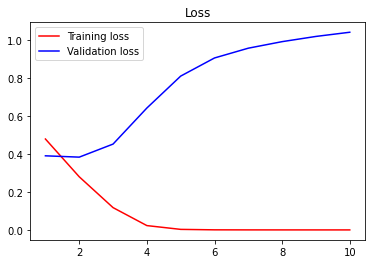

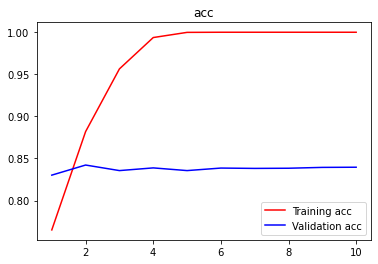

In [14]:
import matplotlib.pyplot as plt
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss ) + 1)
plt.title('Loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

plt.cla()
val_loss = history.history['val_acc']
loss = history.history['acc']
epochs = range(1, len(loss ) + 1)
 
plt.title('acc')
plt.plot(epochs, loss, 'red', label='Training acc')
plt.plot(epochs, val_loss, 'blue', label='Validation acc')
plt.legend()
plt.show()

# Evaluation

[[2177  366]
 [ 423 2034]]
              precision    recall  f1-score   support

           0     0.8373    0.8561    0.8466      2543
           1     0.8475    0.8278    0.8376      2457

    accuracy                         0.8422      5000
   macro avg     0.8424    0.8420    0.8421      5000
weighted avg     0.8423    0.8422    0.8421      5000



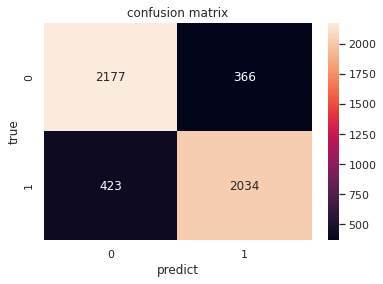

In [15]:
model.load_weights("model/APDCNN.hdf5")
def 给测试集输出指标(val_data,test_y):
    testpre=model.predict([val_data])
    ypre=np.argmax(testpre,axis=1)
    ytrue=np.argmax(test_y,axis=1)


    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    def 混淆矩阵(valp,valy):
        sns.set()
        np.set_printoptions(suppress=True)
        f,ax=plt.subplots()
        valp=np.array(valp)
        valy=np.array(valy)
        C2= confusion_matrix(valy , valp, labels=list(range(len(set(df["category"])))))
        print(C2) #打印出来看看
        sns.heatmap(C2,annot=True,ax=ax,fmt='.20g') #画热力图

        ax.set_title('confusion matrix') #标题
        ax.set_xlabel('predict') #x轴
        ax.set_ylabel('true') #y轴

    def 评价指标(val_data,val_y):
        混淆矩阵(val_data,val_y)
        print(classification_report(val_y,val_data,digits=4))
    评价指标(ypre,ytrue)
给测试集输出指标(val_data,val_y)